In [14]:
# whatsapp_analysis.ipynb

import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to C:\Users\Anshul
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
# ---- Step 1: Load Chat ----

def load_chat(file_path):
    with open(file_path, encoding='utf-8') as f:
        data = f.read()
    return data

raw_data = load_chat('data.txt')

In [3]:
# ---- Step 2: Parse Messages ----

pattern = r"(\d{1,2}/\d{1,2}/\d{2,4}), (\d{1,2}:\d{2} (?:AM|PM)) - (.*?): (.+)"
matches = re.findall(pattern, raw_data)

df = pd.DataFrame(matches, columns=['Date', 'Time', 'User', 'Message'])
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %I:%M %p')
df.drop(['Date', 'Time'], axis=1, inplace=True)

In [4]:
# ---- Step 3: Basic Stats ----

print("Total Messages:", len(df))
print("Total Users:", df['User'].nunique())
print(df['User'].value_counts())

Total Messages: 13
Total Users: 2
User
Alice    8
Bob      5
Name: count, dtype: int64


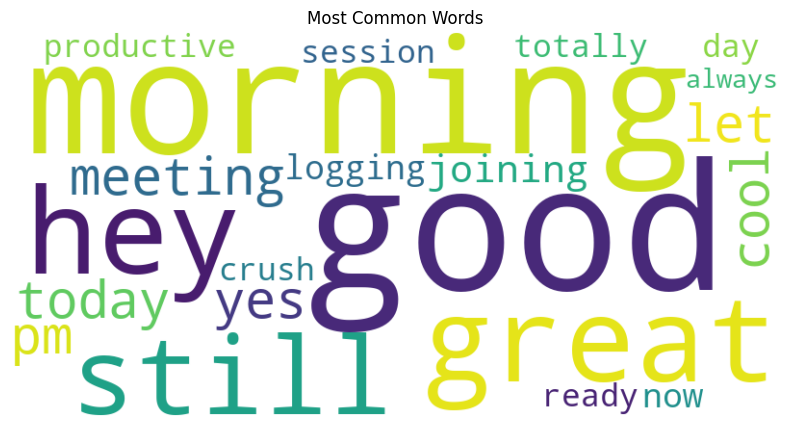

In [5]:
# ---- Step 4: Word Cloud ----

stop_words = set(stopwords.words('english'))
text = ' '.join(df['Message'].dropna())
words = ' '.join([word for word in text.lower().split() if word not in stop_words])

wc = WordCloud(width=800, height=400, background_color='white').generate(words)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words')
plt.show()

In [6]:
# ---- Step 5: Sentiment Analysis ----

analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(message):
    score = analyzer.polarity_scores(message)
    return score['compound']

df['Sentiment'] = df['Message'].apply(analyze_sentiment)
df['Sentiment_Label'] = df['Sentiment'].apply(
    lambda x: 'Positive' if x > 0.05 else 'Negative' if x < -0.05 else 'Neutral'
)

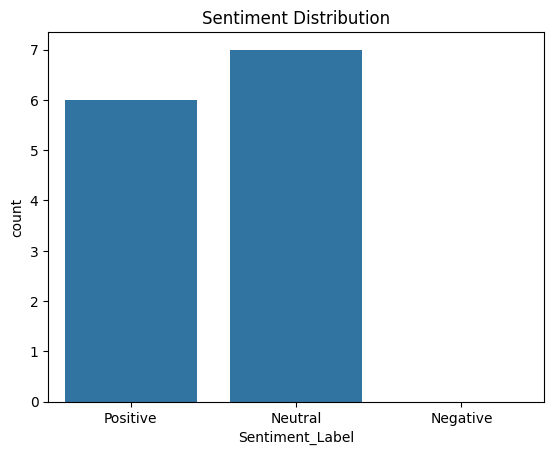

In [7]:
# Plot Sentiment Distribution
sns.countplot(data=df, x='Sentiment_Label', order=['Positive', 'Neutral', 'Negative'])
plt.title('Sentiment Distribution')
plt.show()

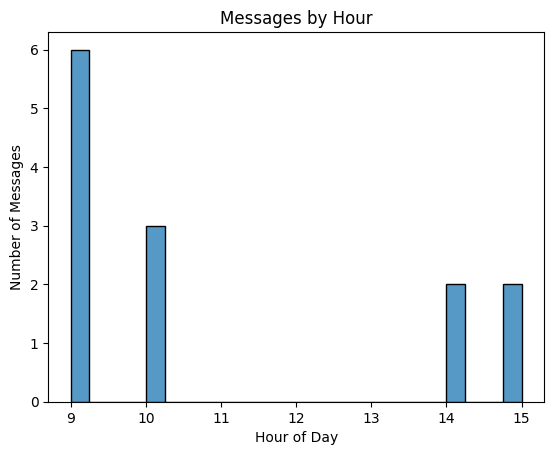

In [8]:
# ---- Step 6: Activity by Hour ----

df['Hour'] = df['Datetime'].dt.hour
sns.histplot(df['Hour'], bins=24, kde=False)
plt.title('Messages by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Messages')
plt.show()

  Emoji  Count
0     😊      1
1     👍      1
2     💯      1
3     ☀      1
4     💪      1


C:\Users\Anshul Singh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Anshul Singh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128175 (\N{HUNDRED POINTS SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Anshul Singh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128170 (\N{FLEXED BICEPS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


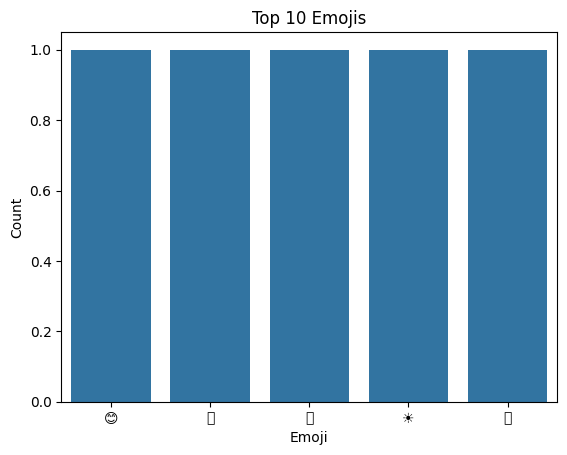

In [9]:
### ---- Step 7: Emoji Analysis ----

import emoji
from collections import Counter

# Extract emojis from messages
def extract_emojis(message):
    return ''.join(c for c in message if c in emoji.EMOJI_DATA)

df['Emojis'] = df['Message'].apply(extract_emojis)

# Flatten all emojis
all_emojis = ''.join(df['Emojis'].tolist())
emoji_freq = Counter(all_emojis)

# Top 10 emojis
top_emojis = pd.DataFrame(emoji_freq.most_common(10), columns=['Emoji', 'Count'])
print(top_emojis)

# Bar plot
sns.barplot(data=top_emojis, x='Emoji', y='Count')
plt.title('Top 10 Emojis')
plt.show()


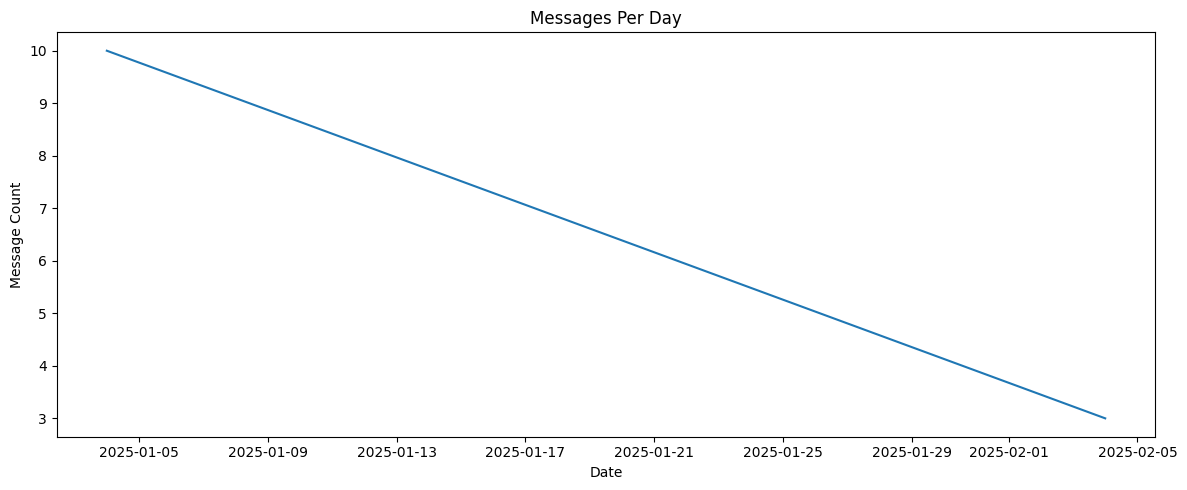

In [10]:
# ---- Step 8: Most Active Days ----

df['DateOnly'] = df['Datetime'].dt.date
daily_counts = df['DateOnly'].value_counts().sort_index()

plt.figure(figsize=(12,5))
daily_counts.plot()
plt.title('Messages Per Day')
plt.xlabel('Date')
plt.ylabel('Message Count')
plt.tight_layout()
plt.show()


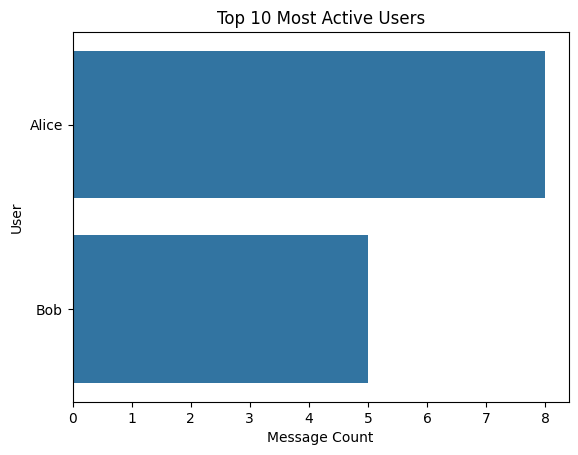

In [11]:
# ---- Step 9: User Activity ----

user_counts = df['User'].value_counts().head(10)

sns.barplot(y=user_counts.index, x=user_counts.values)
plt.title('Top 10 Most Active Users')
plt.xlabel('Message Count')
plt.ylabel('User')
plt.show()


In [12]:
# ---- Step 10: Most Common Words per User ----


from collections import defaultdict
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# Create a word frequency dictionary for each user
user_words = defaultdict(list)

for _, row in df.iterrows():
    words = word_tokenize(row['Message'].lower())
    filtered_words = [w for w in words if w.isalpha() and w not in stop_words]
    user_words[row['User']].extend(filtered_words)

# Display top words per user
for user, words in list(user_words.items())[:3]:  # Show top 3 users only
    print(f"Top words used by {user}:")
    print(Counter(words).most_common(10))
    print('---')


Top words used by Alice:
[('hey', 1), ('great', 1), ('still', 1), ('meeting', 1), ('today', 1), ('cool', 1), ('logging', 1), ('totally', 1), ('good', 1), ('morning', 1)]
---
Top words used by Bob:
[('good', 1), ('yes', 1), ('let', 1), ('pm', 1), ('joining', 1), ('productive', 1), ('session', 1), ('morning', 1), ('ready', 1), ('crush', 1)]
---


[nltk_data] Downloading package punkt to C:\Users\Anshul
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


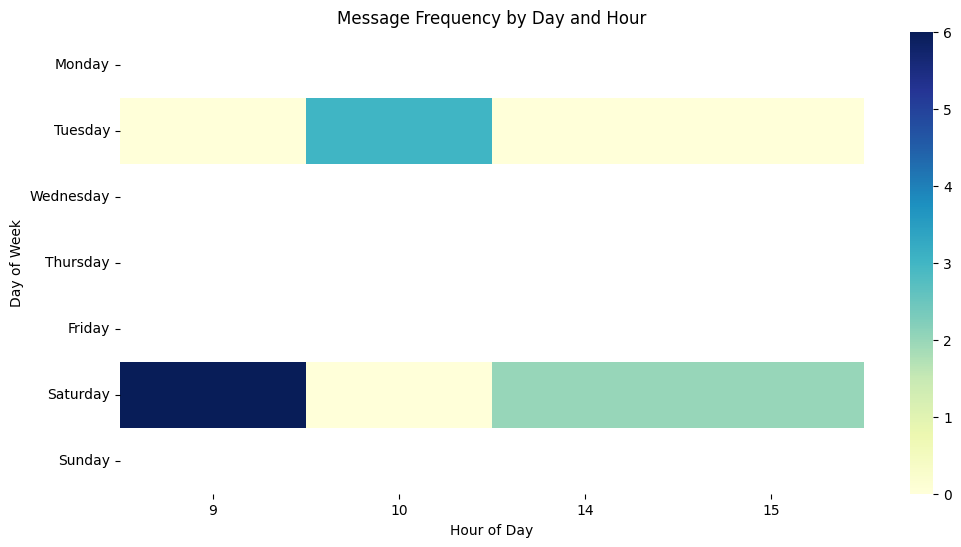

In [13]:
# ---- Step 11: Hourly Heatmap (Activity by Day and Hour) ----


df['Day'] = df['Datetime'].dt.day_name()
df['Hour'] = df['Datetime'].dt.hour

pivot = df.pivot_table(index='Day', columns='Hour', values='Message', aggfunc='count').fillna(0)

# Reorder days
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot = pivot.reindex(days_order)

plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap='YlGnBu')
plt.title('Message Frequency by Day and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()
